In [1]:
import sys 
import os
import cymetric as cym
import pandas as pd
import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm

%matplotlib inline

In [11]:
# deploy inst managed
db_deploy = cym.dbopen('./deployinst/cyclus.sqlite')
evd = cym.Evaluator(db=db_deploy, write=False)
# growth region managed
db_growth = cym.dbopen('./growthregion/cyclus.sqlite')
evg = cym.Evaluator(db=db_growth, write=False)

# Difference in Mass Flows:

Deploy Inst sim a little less material than Growth Region sim

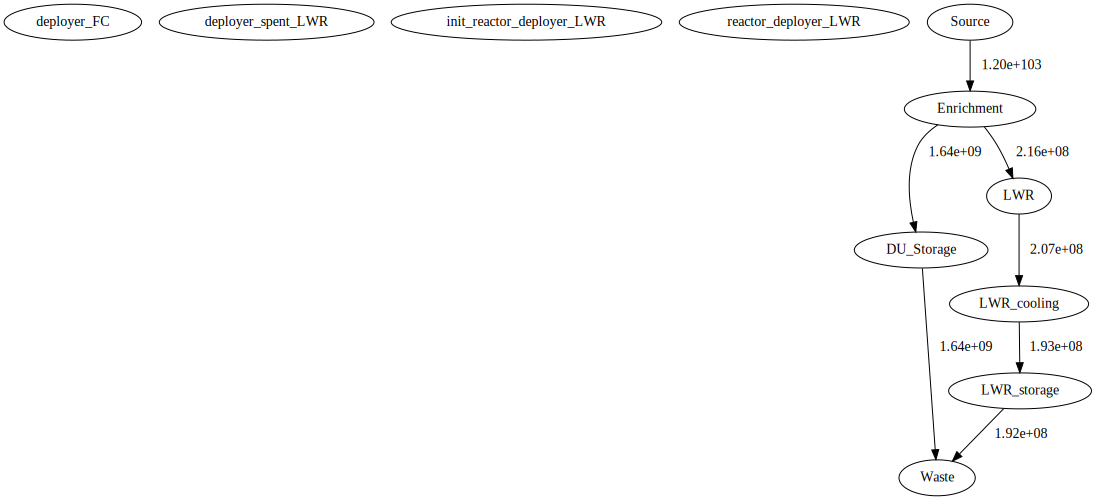

In [3]:
cgr.flow_graph(evd, label='mass')

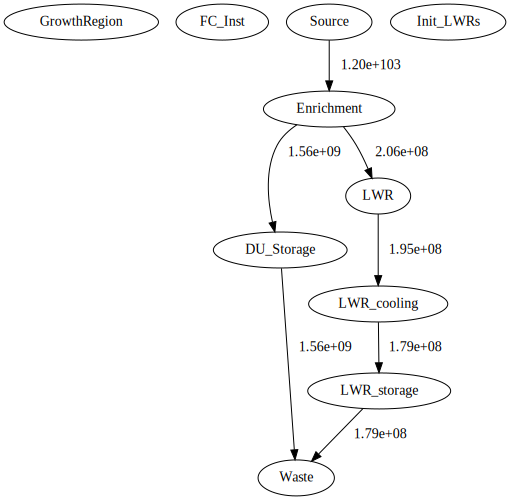

In [12]:
cgr.flow_graph(evg, label='mass')

# Compare the comm decomm (and cumsums) of reactors in each sim (code from cymetric examples)

In [13]:
def rxtr_enter_exit(evaluator):
        
    comm = evaluator.eval('BuildSeries')
    decomm = evaluator.eval('DecommissionSeries')

    neg = -decomm['Count']
    decomm = decomm.drop('Count',axis=1)
    decomm = pd.concat([decomm, neg],axis=1)
    
    comm = comm.rename(columns={'EnterTime':'Time'})
    decomm = decomm.rename(columns={'ExitTime':'Time'})
    
    comm = comm.pivot('Time','Prototype')['Count'].reset_index()
    decomm = decomm.pivot('Time','Prototype')['Count'].reset_index()
    comm_decomm = pd.merge(comm, decomm, left_on='Time', right_on='Time', how='outer', sort=True, \
                           suffixes=('_enter', '_exit')).fillna(0)
    
    comm_decomm.Time = comm_decomm.Time.astype(int)
    
    return comm_decomm

In [14]:
comm_decom_d = rxtr_enter_exit(evd)
comm_decom_g = rxtr_enter_exit(evg)

In [15]:
comm_decom_d.columns

Index(['Time', 'DU_Storage', 'Enrichment', 'LWR_enter', 'LWR_cooling',
       'LWR_storage', 'Source', 'Waste', 'deployer_FC', 'deployer_spent_LWR',
       'init_reactor_deployer_LWR', 'reactor_deployer_LWR', 'LWR_exit'],
      dtype='object', name='Prototype')

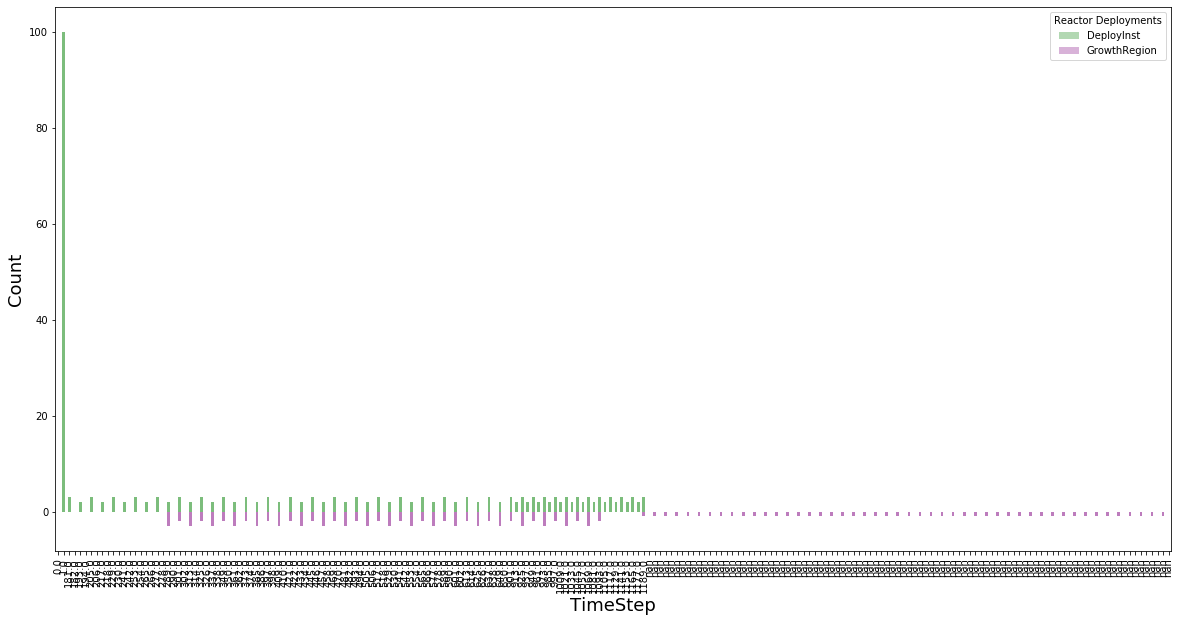

In [16]:

colors = ['green', 'purple']

data = [comm_decom_d['Time'], comm_decom_d['LWR_enter'], comm_decom_d['LWR_enter'], 
        comm_decom_g['Time'], comm_decom_g['LWR_exit'], comm_decom_g['LWR_exit']
       ]
headers = ['Time (d)', 'Enter (d)', 'Exit (d)', 
           'Time (g)', 'Enter (g)', 'Exit (g)'
          ]
plot_df = pd.concat(data, axis=1, keys=headers)
        
ax = plot_df[['Time (d)', 'Enter (d)', 'Enter (g)']].plot.bar(x='Time (d)', figsize=(20,10), stacked=True, \
                                                              legend=False, color=colors, alpha=0.3)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst')
legend.get_texts()[1].set_text('GrowthRegion')
legend.set_title('Reactor Deployments')
plot_df[['Time (d)', 'Exit (d)', 'Exit (g)']].plot.bar(x='Time (d)', ax=ax, figsize=(20,10), stacked=True, \
                                                       legend=False, color=colors, alpha=0.3)
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Count', fontsize=18)
plt.show()

In [17]:
plot_df[str('deploy') + '_total'] = comm_decom_d[str('LWR') + '_enter'].cumsum() + \
                                    comm_decom_d[str('LWR') + '_exit'].cumsum()

plot_df[str('growth') + '_total'] = comm_decom_g[str('LWR') + '_enter'].cumsum() + \
                                    comm_decom_g[str('LWR') + '_exit'].cumsum()

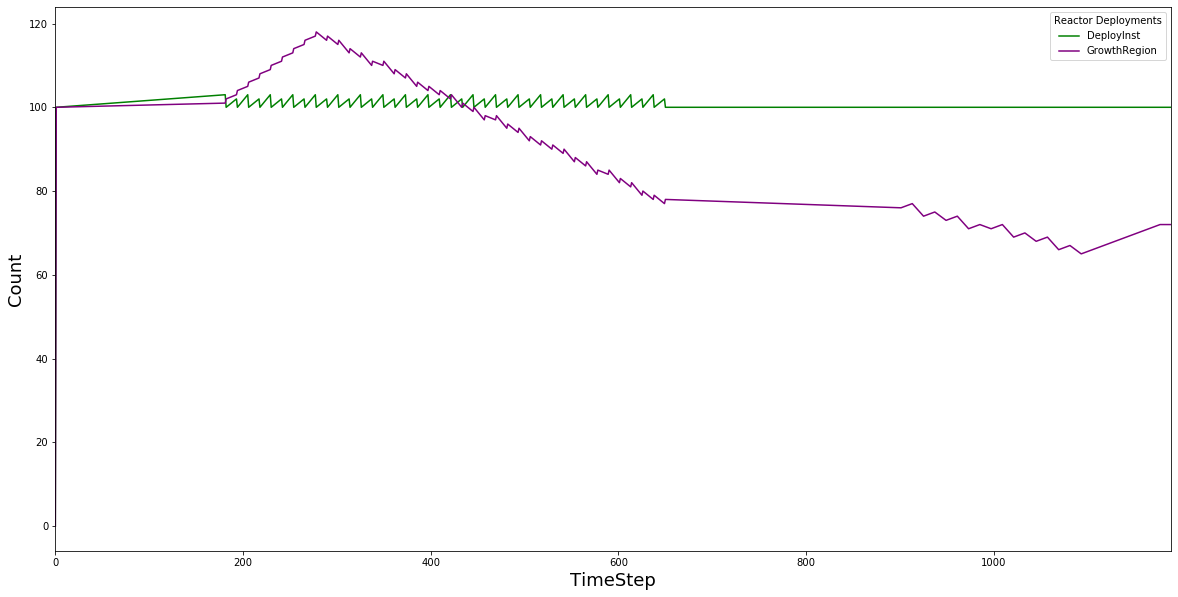

In [18]:
colors = ['green', 'purple']
ax = plot_df[['Time (d)', 'deploy_total', 'growth_total']].plot(x='Time (d)', figsize=(20,10), \
                                                                legend=False, color=colors)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst')
legend.get_texts()[1].set_text('GrowthRegion')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Count',fontsize=18)
plt.show()

# Power Steady @ 100 GWe / yr